# Implementing MH-MCMC

_Thomas Wiemann_

_TA Discussion \# 2_  
_ECON 31740_  

_January 24, 2022_  

## Section 0: Preliminaries
This notebook implements two simple Metropolis-Hastings Markov chain Monte Carlo (MH-MCMC) samplers and illustrates simple diagnostic tools. 

The code can be downloaded via this [link](https://thomaswiemann.com/assets/teaching/Winter2022-Econ-31740/Econ_31740_discussion_2.ipynb).

In [26]:
# Libraries
library(doParallel) # parallel computation
library(foreach) # prallel computation 
library(ggplot2) # plots
library(MCMCpack) # effective sample size

In [2]:
# Change plot size to 8 x 6
options(repr.plot.width = 8, repr.plot.height = 6)

# Turn off options (bad practice!)
options(warn=-1)

## Section 1: Another Exploration-Exploitation Trade-Off

Exploration-exploitation trade-offs frequently occure in optimization and decision procedures, and MH-MCMC samplers are no exception. This section illustrates how the choice of proposal distribution affects sampling behavior, and how this can be interpreted within the exploration-exploitation trade-off.

#### Section 1.1: Target Distribution 

The target distribution considered in this example is given by
    \begin{align*}
        \pi(x)
        \propto
        \cos^{2}(x) \times \cos^{2}(1.5x) \times \phi(x; 2, 1),
    \end{align*}
    where $\phi(\cdot; \mu, \sigma^2)$ denotes the normal pdf with mean $\mu$ and variance $\sigma^2$. (Note that the given density is given only up to a normalizing constant.) 
    
The code below plots the associated probability density.

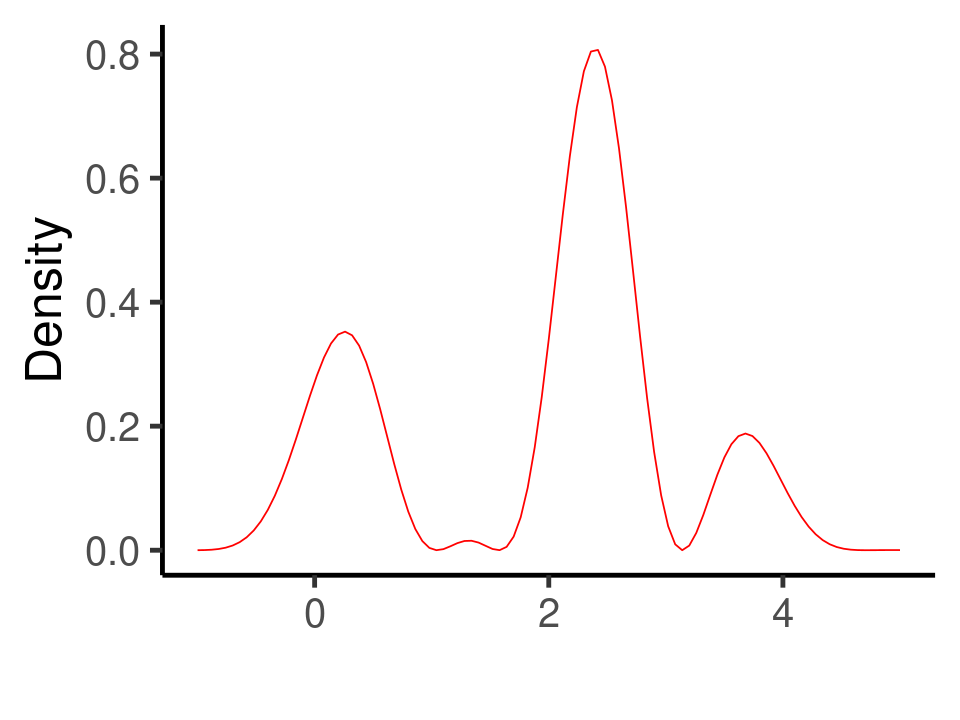

In [3]:
# Get the true density
true_d <- function(x) cos(x)^2 * cos(1.5 * x)^2 * dnorm(x, 2, 1)
normalizing_c <- 1 / integrate(true_d, -20, 20)[1]$value
true_d <- function(x) cos(x)^2 * cos(1.5 * x)^2 * dnorm(x, 2, 1) * normalizing_c

# Density plots with highest density intervals
ggplot(data.frame(x = seq(-1, 5, 0.1)), aes(x = x)) + 
    stat_function(fun = true_d, colour = "red") + 
    ylab("Density") + 
    xlab("") +
    theme_classic(base_size = 30)

The multi-modal nature of the distribution creates a challenge for the sampler as it must be able to switch between modes (exploration) while also obtaining samples from within each mode (exploitation). Researchers specifying the sampler can affect the behavior of the chain with their choice proposal distribution.

To obtain intuition, consider the random walk proposal distribution given by 
\begin{align}
    q(x'\vert x) = \frac{1}{2\alpha}\mathbf{1}\{x' \in [x - \alpha, x + \alpha]\},
\end{align}
where the hyperparameter $\alpha$ controls the variance of the proposal. 

A larger proposal variance has two primary effects. On one hand, proposals further apart allow the chain to more easily jump between modes of the target distribution, benefiting exploration. On the other hand, far-off proposals may notably reduce the acceptance probability, reducing exploitation.

To illustrate this trade-off, we will consider three seperate samplers with $\alpha \in \{0.75, 4, 15\}$. 

#### Section 1.2: MH-MCMC Implementation

To begin with implementation, we first derive the MH-acceptance ratio. We have
\begin{align}
\begin{aligned}
    \frac{\pi(x')}{\pi(x)}\frac{q(x\vert x')}{q(x'\vert x)} & =  \frac{\cos^{2}(x') \times \cos^{2}(1.5x') \times \phi_{2}(x')}{\cos^{2}(x) \times \cos^{2}(1.5x) \times \phi_{2}(x)}\frac{q(x\vert x')}{q(x\vert x)} \\
    &= \frac{\cos^{2}(x') \times \cos^{2}(1.5x')}{\cos^{2}(x) \times \cos^{2}(1.5x)}\exp\left(-\frac{1}{2}\left((x'-2)^2 - (x-2)^2\right)\right)\frac{q(x\vert x')}{q(x'\vert x)},
\end{aligned}
\end{align}
where it holds that the proposal is symmetric -- i.e., $q(x'\vert x) = q(x\vert x')$ -- so that the acceptance probability is given by 
\begin{align}
\min\left\{1, \frac{\cos^{2}(x') \times \cos^{2}(1.5x')}{\cos^{2}(x) \times \cos^{2}(1.5x)}\exp\left(-\frac{1}{2}\left((x'-2)^2 - (x-2)^2\right)\right)\right\}.
\end{align}

In [4]:
# MH acceptance probability with uniform random walk proposal (symmetric)
p_accept <- function(x, y) {
  a <- ((cos(y)^2 * cos(1.5*y)^2) / (cos(x)^2 * cos(1.5*x)^2)) * exp(0.5*((x-2)^2-(y-2)^2))
  return(min(1, a))
}#P_ACCEPT

The MH-MCMC sampler can then be implemented in the usual fashion. I run each chain for 2,000 samples.

In [5]:
# Sampling hyperparameters
N = 2000
alpha_list <- c(0.75, 4, 15) 

# Run mcmc sampler for different values of alpha
x_mat <- matrix(0, N, length(alpha_list))
for(j in 1:length(alpha_list)) {
  x_mat[1, j] <- 10  
  for (i in 2:N) {
    u <- runif(1)
    y <- x_mat[i-1, j] + alpha_list[j]*(1-2*runif(1))
    if (u < p_accept(x_mat[i-1, j], y)) {
      x_mat[i, j] <- y
    } else {
      x_mat[i, j] <- x_mat[i-1, j]
    }#IFELSE
  }#FOR
}#FOR

#### Section 1.3: Density Plots

The sampling distributions for each sampler are presented below. We see that -- in line with expectations -- the sampling distribution for $\alpha=0.75$ appears to mix well within a particular mode, yet, largely distorts the proportion of each mode in the total distribution. For $\alpha=15$, the proportion of each mode is better approximated, yet, a few values with very high values at which the chain was stuck for many iterations stand out. A reasonable middle ground is provided by $\alpha=4$, which appears to better mirror the target distribution within modes than $\alpha=15$ and better across modes than $\alpha=0.75$.

In [6]:
# Change plot size to 16 x 6
options(repr.plot.width = 16, repr.plot.height = 6)

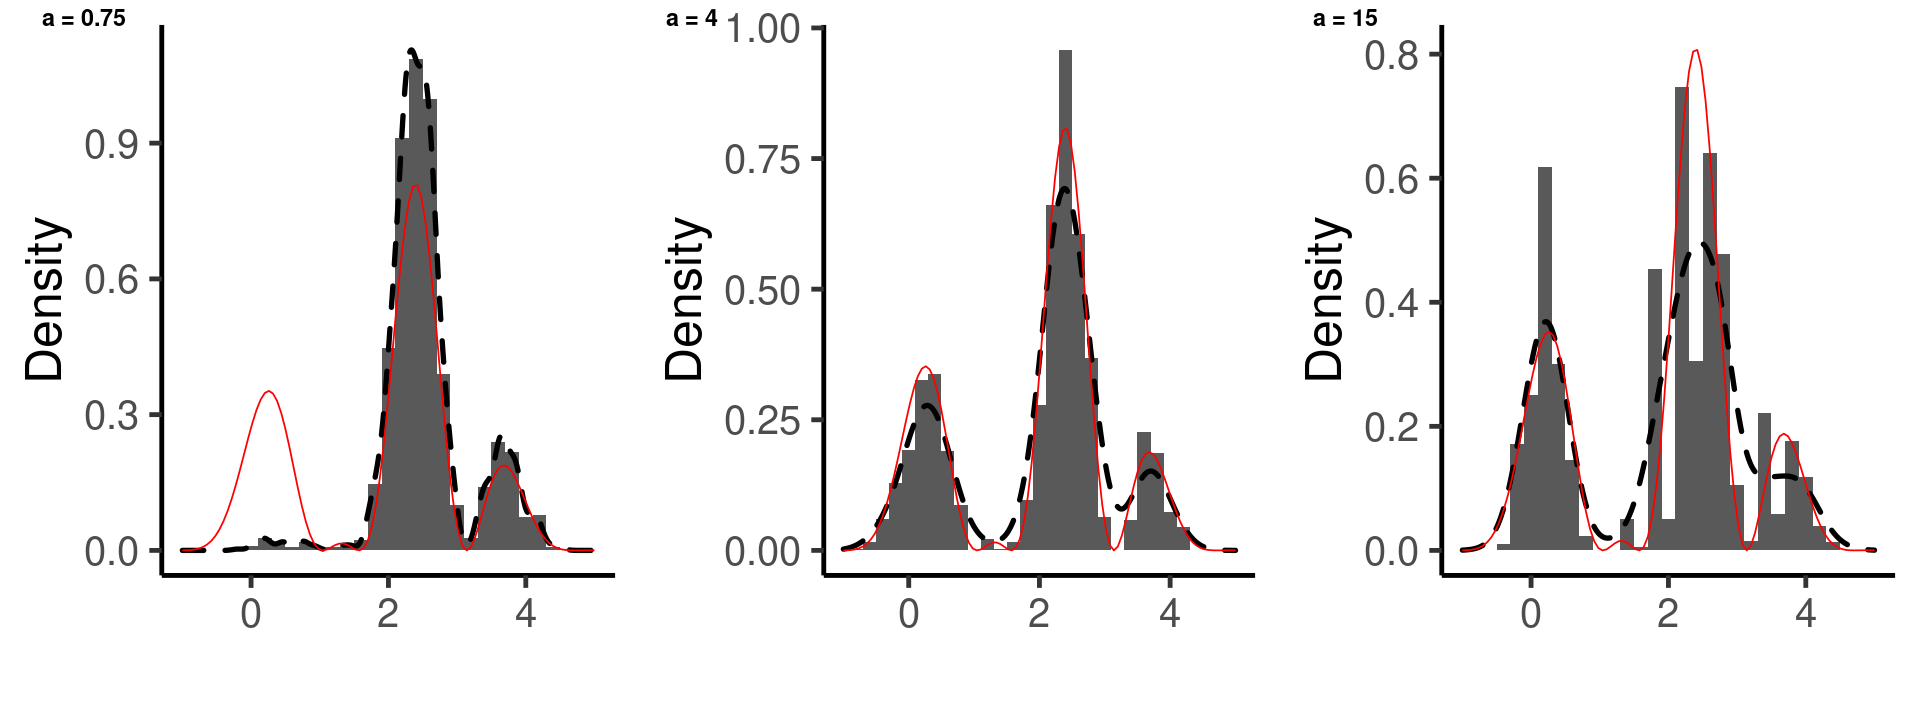

In [7]:
# Density plots
plt_list <- list(NULL)
for (j in 1:3) {
plt_list[[j]] <- ggplot(data.frame(X = x_mat[-c(1:100), j]), aes(x = X)) + 
    geom_histogram(aes(y=..density..), binwidth = 0.2) + 
    geom_density(size = 1.5, linetype = "dashed") + 
    stat_function(fun = true_d, colour = "red") + 
    ylab("Density") + 
    xlab("") +
    xlim(c(-1,5)) +
    theme_classic(base_size = 30)
}#FOR
ggpubr::ggarrange(plt_list[[1]], plt_list[[2]], plt_list[[3]], 
                  nrow = 1, labels = c("a = 0.75", "a = 4", "a = 15"))

#### Section 1.4: Diagnostic Tools

In practice, the researcher does not have access to the "true" target distribution. To assess whether the sampler is mixing appropriately, she must instead rely on diagnostic tools. There is a large variety of MCMC diagnostic tools; we will focus on the most basic (and easiest to implement). 

The below figures give the trace corresponding to each chain. We see that for $\alpha = 0.75$, the chain has a considerably larger burn-in period and only infrequently transitions between modes of the distributions. While allowing for good mixing within modes, the small steps also induce very high autocorrelations. For $\alpha = 15$, the chain frequently switches between modes but is also often "stuck" at a particular value for a considerable number of iterations and does therefore not mix well within each mode. A suitable compromise between the two extremes appears to be $\alpha = 4$. It frequently transitions between modes, yet, with an acceptance rate of 0.286, is not "stuck" as frequently. 

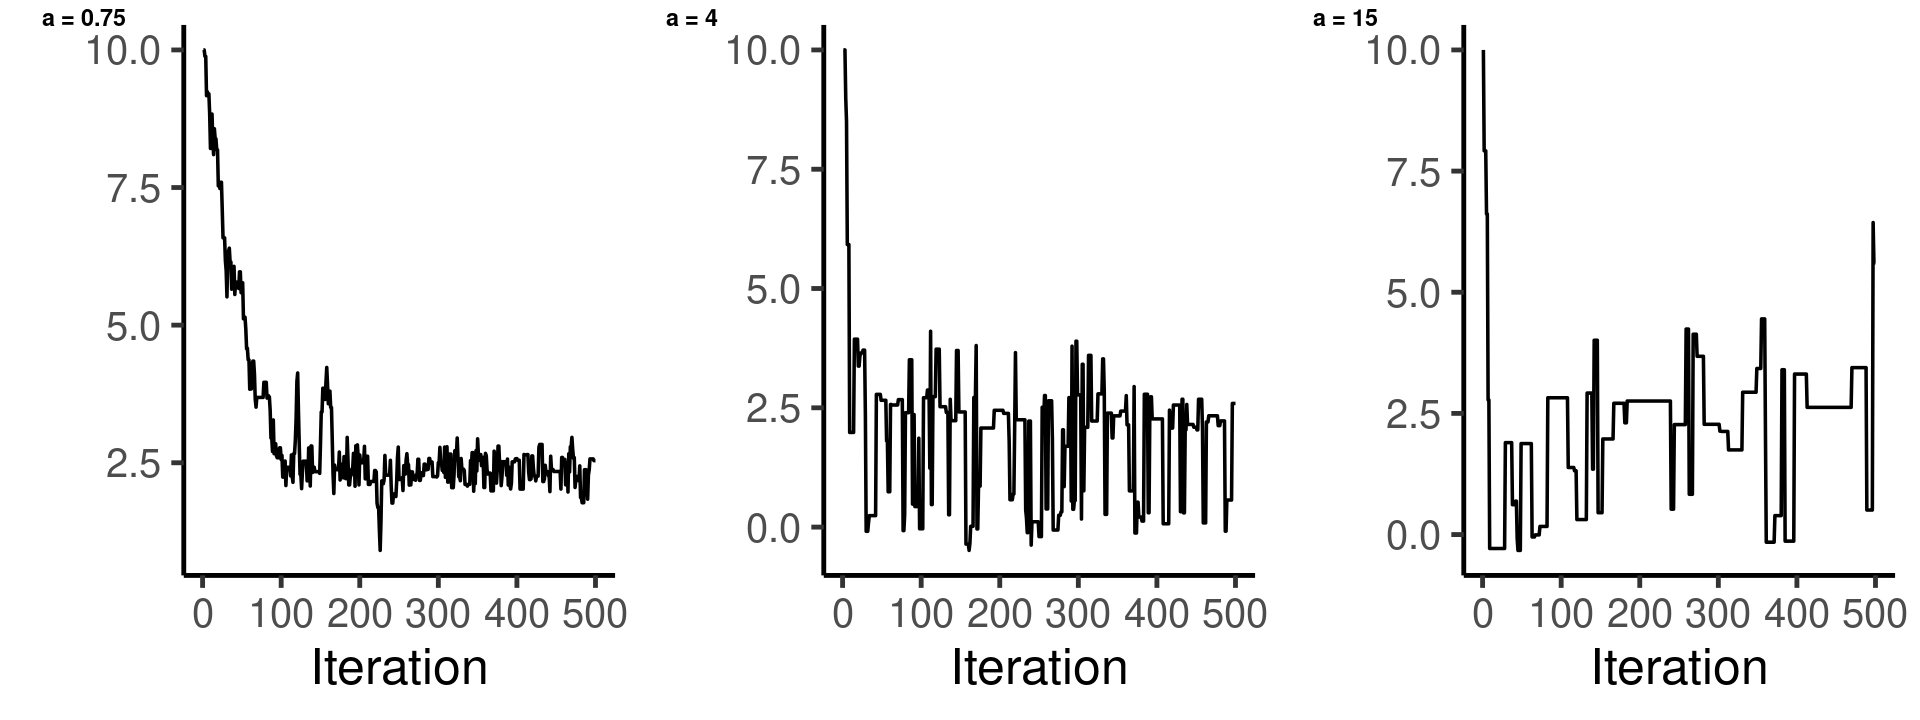

In [8]:
# Plot autocorrelations 
plt_list <- list(NULL)
for (j in 1:3) {
    df <- data.frame(t = c(1:500), X = x_mat[1:500, j])
    plt_list[[j]] <- ggplot(data = df, aes(x = t, y = X)) + 
    geom_line(size = 1) +
    ylab("") +
    xlab("Iteration") +
    theme_classic(base_size = 30)      
}#FOR
ggpubr::ggarrange(plt_list[[1]], plt_list[[2]], plt_list[[3]], 
                  nrow = 1, labels = c("a = 0.75", "a = 4", "a = 15"))

In [9]:
# Acceptance rate
apply(x_mat, 2, function(x){length(unique(x))/N})

[1] 0.5775 0.2780 0.0735

The quickly decreasing autocorrelations further indicate that the $\alpha=4$ chain mixes well in comparison to $\alpha=0.75$ and $\alpha = 15$.

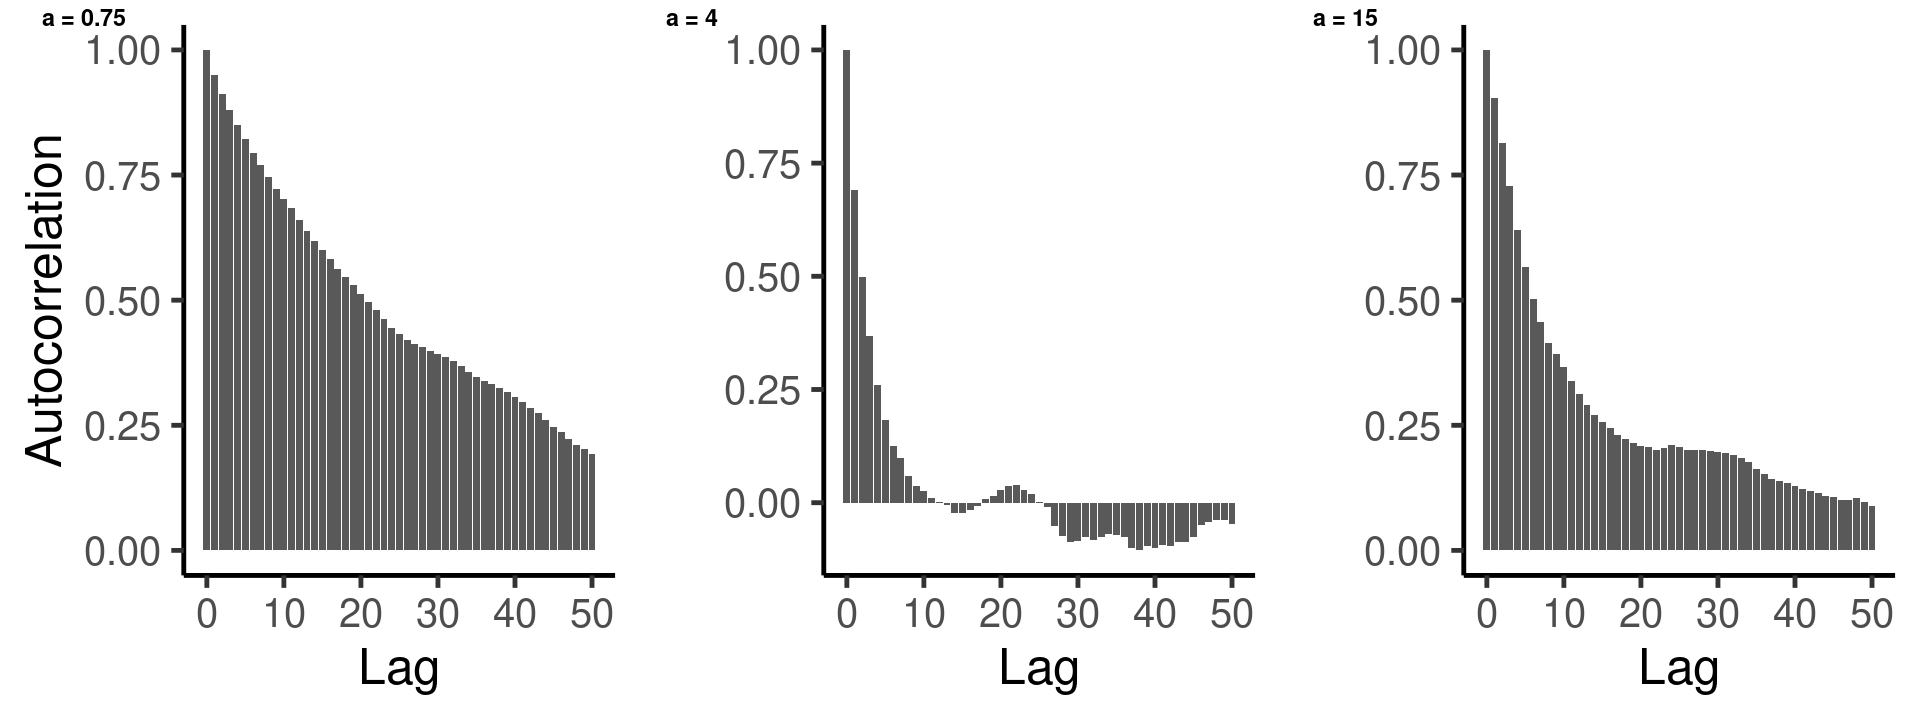

In [10]:
# Plot autocorrelations 
plt_list <- list(NULL)
for (j in 1:3) {
    acf_j <- acf(x_mat[, j], lag.max = 50, type = "correlation", plot = F)$acf
    plt_list[[j]] <- ggplot(data = data.frame(lag = c(0:50), acf = acf_j), 
              aes(x = lag, y = acf)) + 
      geom_bar(stat = "identity") +
      ylab("") +
      xlab("Lag") +
      theme_classic(base_size = 30)
    if (j == 1) plt_list[[j]] <- plt_list[[j]] + ylab("Autocorrelation")
      
}#FOR
ggpubr::ggarrange(plt_list[[1]], plt_list[[2]], plt_list[[3]], 
                  nrow = 1, labels = c("a = 0.75", "a = 4", "a = 15"))

Note that the issues discussed here concern convergence rates. With sufficiently many draws, the samplers result in very similar posterior density estimates.

In [11]:
# Check effective sample size
round(effectiveSize(as.mcmc(x_mat)),2)

var1   var2   var3 
 37.95 336.69  94.55

## Section 2: Bivariate Random Effects Regression

This section considers a bivariate random effects regression model given by
\begin{align}
        y_{i}
        =
        X_{i}\beta + W_{i}b_{i} + \varepsilon_{i},
        \quad \forall i = 1, \ldots, 100,
\end{align}
where $b_{i}\sim N(0,\sigma_{b}^{2})$ is a random effect, $W_{i}$ is $2\times1$,and $X_{i}$ is $2\times4$. Assume $\varepsilon_{i}\overset{iid}{\sim} N(0, \sigma_{\varepsilon}^{2}I_{2})$ and $b_i \perp \varepsilon_{i}$. The data $\mathcal{D}:= \{y_i, X_i, W_i\}_{i=1}^{100}$ can be generated in a straightforward manner, setting $\beta_0 = (1, 2, 3, 4)$ and $\sigma^2_{0b} = \sigma^2_{\varepsilon}=3$.

In [12]:
# Set true parameter values
true_beta = matrix(c(1:4), 4, 1)
true_sgm2_b = 3
true_sgm2_e = 3

# Simulate data
nobs = 100 # number of observations
X <- array(rnorm(2*4*nobs, 0, 1), dim = c(2, 4, nobs))
W <- matrix(rnorm(2*nobs, 0, 1), 2, nobs)
y <- matrix(0, 2, nobs)
for(i in 1:nobs) {
  y[, i] <- X[, , i] %*% true_beta + W[, i] * rnorm(2, 0, sqrt(true_sgm2_b)) + 
    rnorm(2, 0, sqrt(true_sgm2_e))
}#FOR 

The goal is now to (1) formulate appropriate prior distributions for the unknown parameters $(\beta, \sigma_{b}, \sigma_{\varepsilon})$, (2) derive the posterior distribution $\pi(\beta, \sigma_{b}, \sigma_{\varepsilon}\vert \mathcal{D})$, and (3) obtain samples from the posterior from an appropriate MH-MCMC sampler.

#### Section 2.1: Likelihood of the Data

To derive the likelihood of the data $L\big(\{y_i, X_i, W_i\}_{i=1}^N|\boldsymbol{\theta}\big)$, note that under the assumption under the assumption that $b_i \perp \varepsilon_i$ we have 
\begin{align}
\begin{aligned}
        &(W_i b_i + \varepsilon_i) \sim N(0, \Sigma_i), \\
    \textrm{where } &\Sigma_i = W_i W_i^\top \sigma_b^2 + I_2 \sigma_\varepsilon^2,
\end{aligned}
\end{align}
where $W_i = [w_{i1}, w_{i2}]^\top$ is fixed. Under exchangability of the observations, we may then write the likelihood as
\begin{align}
\begin{aligned}
            L\big(\{y_i, X_i, W_i\}_{i=1}^N|\boldsymbol{\theta}\big) &\propto \bigg[\prod_{i=1}^N  \big|\Sigma_i\big|^{-\frac{1}{2}}\bigg]\exp\bigg\{-\frac{1}{2}\sum_{i=1}^N (y_i - X_i\beta)^\top \Sigma_i^{-1} (y_i - X_i\beta) \bigg\}, 
\end{aligned}
\end{align}
where $\big|\cdot \big|$ denotes the determinant.

The below code snippit implements the log-likelihood for numerical stability.

In [13]:
# log-likelihood
get_logl <- function(y, X, W, beta, sgm2_b, sgm2_e) {
  # Get diagonal covariance terms 
  mat_Sigmas <- apply(W, 2, function(x){ x^2 * sgm2_b + sgm2_e })
  
  # Compute determinants of Sigma_i
  mat_det <- apply(mat_Sigmas, 2, function(x){ sqrt(x[1] * x[2]) })

  # Compute scaled squared deviations
  err <- y - apply(X, c(3), function(x){ x %*% beta })
  sq_devs <- matrix(0, ncol(y), 1)
  for(i in 1:ncol(y)) {
    sq_devs[i] <- t(err[, i]) %*% diag(1/mat_Sigmas[, i]) %*% err[, i]
  }#FOR
  
  # Calculate and return log likelihood
  logl <- -sum(log(mat_det)) - 0.5 * sum(sq_devs)
  return(logl)
}#GET_LOGL

#### Section 2.2: Prior Specification

Independent Gamma priors for $\sigma_j^{-2}, j\in\{b, \varepsilon\}$ are given by
\begin{align}
    \begin{aligned}
                \pi_{\sigma_j^{-2}}(x) \propto (x)^{\lambda_j \gamma_j-1}\exp\big\{-\gamma_j x \big\},
    \end{aligned}
\end{align}
where $\{\lambda_j, \gamma_j\}$ are hyperparameters. Note that this parametrization differs from conventional specifications of the Gamma distribution. The benefit of the parameters as defined here is that  $E_{\pi}[\sigma_j^{-2}] = \lambda_j$ and $Var_\pi(\sigma_j^{-2}) = \frac{\lambda_j}{\gamma_j}$ so that a desired location and variance can more easily be translated into hyperparameter values.

A multivariate normal prior for $\beta$ is given by
\begin{align}
    \pi_\beta(x) \propto \big|\Sigma_\beta\big|^{-\frac{1}{2}}\exp\big\{-\frac{1}{2}(x-\mu)^\top \Sigma_\beta^{-1}(x-\mu)\big\},
\end{align}
where $\{\mu, \Sigma_\beta\}$ are hyperparameters. As $E_\pi[\beta] = \mu$ and $Cov_\pi(\beta)=\Sigma_\beta$, we may easily translate a desired location and covariance structure into hyperparameter values.

The joint prior for $\boldsymbol{\theta} := \{\beta, \sigma_b, \sigma_\varepsilon\}$ is then given by
\begin{align}
    \pi(\boldsymbol{\theta}) \propto  \pi_\beta(\beta)\pi_{\sigma_b^{-2}}(\sigma_b^{-2})\pi_{\sigma_\varepsilon^{-2}}(\sigma_\varepsilon^{-2}).
\end{align}

The prior hyperparameters are chosen with high-variance to avoid notable influence on the posterior distribution. It's possible to choose parameters such that the variances are much larger. Given the 100 data points and the relative simplicity of the model, however, this is not expected to have a noticeable effect on the estimates. The specified priors may therefore be interpreted as being uninformative.

In [14]:
# prior on beta
mu = rep(0, 4)
Sgm_beta = diag(rep(1, 4)) * 10 #  the higher, the less "informative"

#prior on precision 1/sgm2_j
lambda_b = lambda_e = 1 # the lower, the lower the expected precision
gamma_b = gamma_e = 0.5 # the lower, the less "informative"

#### Section 2.3: Posterior Distribution

Combining the derived likelihood and the joint priors, the posterior distribution is then characterized by
\begin{align}
    \begin{aligned}
            \pi\big(\boldsymbol{\theta}|\{y_i, X_i, W_i\}_{i=1}^N\big) \propto L\big(\{y_i, X_i, W_i\}_{i=1}^N|\boldsymbol{\theta}\big) \pi(\boldsymbol{\theta}).
    \end{aligned} 
\end{align}

In [15]:
# log posterior
get_logtarget <- function(beta, sgm2_b, sgm2_e,
                          y, X, W, 
                          mu, Sgm_beta,
                          lambda_b, gamma_b, 
                          lambda_e, gamma_e) {
  get_logl(y, X, W, beta, sgm2_b, sgm2_e) + 
    dnorm(beta, mu, sqrt(diag(Sgm_beta)), log = T) + 
    dgamma(1/sgm2_b, lambda_b*gamma_b, gamma_b, log = T) + 
    dgamma(1/sgm2_e, lambda_b*gamma_b, gamma_b, log = T)
}#GET_LOGTARGET

#### Section 2.4: Proposal Distribution

I implement a MH-MCMC sampler with random walk proposals. For the $\beta$ parameters, increments are given by a uniform distribution with span $1$. For the precision parameters, proposals are generated by a gamma distribution centered at the previous draw.

Note that the proposal for the precision parameters are asymmetric and are hence adjusted for in the acceptance probability.

In [16]:
# Propose new 1/sgm2_j (asymmetric!)
proposal_sgm2_inv <- function(sgm2_inv_old, q_sgm_gamma = 1) {
  sgm2_inv_new <- rgamma(1, sgm2_inv_old * q_sgm_gamma, q_sgm_gamma)
  lq_forward <- dgamma(sgm2_inv_new, sgm2_inv_old * q_sgm_gamma, q_sgm_gamma, 
                      log = T)
  lq_backward <- dgamma(sgm2_inv_old, sgm2_inv_new * q_sgm_gamma, q_sgm_gamma, 
                        log = T)
  return(list(new = sgm2_inv_new, 
              lq_forward = lq_forward, lq_backward = lq_backward))
}#PROPOSAL_SGM2_INV

# MH acceptance  
acceptreject <- function(beta_new, sgm2_b_new, sgm2_e_new,
                     beta_old, sgm2_b_old, sgm2_e_old,
                     lq_forward, lq_backward,
                     y, X, W, mu, Sgm_beta, 
                     lambda_b, gamma_b, lambda_e, gamma_e) {
  # calculate alpha 
  log_alpha <-  get_logtarget(beta_new, sgm2_b_new, sgm2_e_new,
                          y, X, W, mu, Sgm_beta, 
                          lambda_b, gamma_b, lambda_e, gamma_e) -
    get_logtarget(beta_old, sgm2_b_old, sgm2_e_old,
                  y, X, W, mu, Sgm_beta, 
                  lambda_b, gamma_b, lambda_e, gamma_e) +
    lq_backward -
    lq_forward
  # Accept randomly
  accept <- log(runif(1)) < min(0, log_alpha)
  return(accept)
}#ACCEPTREJECT


#### Section 2.5: Random Scan MH-MCMC

To circumvent low acceptance probabilities that would occur were the algorithm to update all six parameters jointly, the procedure selects a subset of parameters randomly at each step. This induces greater autocorrelation between samples but appears to be reasonable solution to the curse of dimensionality issue arising here. The sampler is initialized ten times at random starting values (centered around the prior expectation) to facilitate better convergence analysis.

(Notice that running multiple MH-MCMC chains is _embarassingly parallel_. The below code snippit thus parallelizes the procedure.)

In [17]:
# Sampling hyperparameters
nsim <- 10000 # iterations per chain
nchains <- 10 # number of chains

# Parallelization setup
ncores <- parallel::detectCores(logical = F) - 1 
cl <- parallel::makeCluster(ncores, outfile="")
doParallel::registerDoParallel(cl, cores = ncores)
parallel::clusterExport(cl, c("y", "X", "W"),
                        envir = environment())
parallel::clusterExport(cl, c("get_logl", "get_logtarget", 
                              "proposal_sgm2_inv", "acceptreject"),
                        envir = environment())

# Run mcmc chains in parallel
mcmc_res <- foreach::foreach(x = 1:nchains) %dopar% {
  # Initialize parameter matrix w/ prior expectation + noise
  theta_mat <- matrix(0, nsim, 6)
  theta_mat[1, ] <- c(mu, lambda_b, lambda_e) # prior expectation
  theta_mat[1, 1:4] <- theta_mat[1, 1:4] + rnorm(4, 0, 2) # add noise
  theta_mat[1, 5:6] <- theta_mat[1, 5:6] + 
    0.5 * c(lambda_b, lambda_e) * (1 - 2*runif(2))
    
  # Run sequential scan MH-MCMC
  for(i in 2:nsim){
    
    # Draw new proposals
    which_par <- sample(1:3, 1)
    if(which_par == 1) {
      # Update a random subset of the betas (random scan)
      which_beta <- sample(c(1:4), sample(c(1:4), 1))
      beta_new <- theta_mat[i-1, 1:4]
      beta_new[which_beta] <- theta_mat[i-1, which_beta] + 
        0.5*(1-2*runif(length(which_beta)))
      lq_forward <- lq_backward <- 0
      # Copy values for sgm2_j
      sgm2_b_new <- theta_mat[i-1, 5]; sgm2_e_new <- theta_mat[i-1, 6]
    } else if (which_par == 2) {
      # Update sgm2_b
      sgm2_b_prop <- proposal_sgm2_inv(1/theta_mat[i-1, 5], q_sgm_gamma = 50)
      sgm2_b_new <- 1/sgm2_b_prop$new;
      lq_forward <- sgm2_b_prop$lq_forward
      lq_backward <- sgm2_b_prop$lq_backward
      # Copy values for beta and sgm2_e
      beta_new <- theta_mat[i-1, 1:4]; sgm2_e_new <- theta_mat[i-1, 6]
    } else {
      # Update sgm2_e
      sgm2_e_prop <- proposal_sgm2_inv(1/theta_mat[i-1, 6], q_sgm_gamma = 50)
      sgm2_e_new <- 1/sgm2_e_prop$new;
      lq_forward <- sgm2_e_prop$lq_forward
      lq_backward <- sgm2_e_prop$lq_backward
      # Copy values for beta and sgm2_b
      beta_new <- theta_mat[i-1, 1:4]; sgm2_b_new <- theta_mat[i-1, 5]
    }#IFELSE
    
    # Check for acceptance
    accept <- acceptreject(beta_new, sgm2_b_new, sgm2_e_new,
                           theta_mat[i-1, 1:4], 
                           theta_mat[i-1, 5], theta_mat[i-1, 6],
                           lq_forward, lq_backward,
                           y, X, W, mu, Sgm_beta, 
                           lambda_b, gamma_b, lambda_e, gamma_e)
    
    # Update chain
    if(accept) {
      theta_mat[i, 1:4] <- beta_new
      theta_mat[i, 5] <- sgm2_b_new
      theta_mat[i, 6] <- sgm2_e_new
    } else {
      theta_mat[i, 1:4] <- theta_mat[i-1, 1:4]
      theta_mat[i, 5] <- theta_mat[i-1, 5]
      theta_mat[i, 6] <- theta_mat[i-1, 6]
    }#IFELSE
  }#FOR
  
  # Return natrix of samples
  return(theta_mat)
}#FOREACH
  
# Terminate all parrallel clusters
parallel::stopCluster(cl)

#### Section 2.6: Diagnostic Tools

The figure below gives the trace plots of the first 10,000 samples of each chain. The acceptance rate is 0.492. After an initial burn-in period (indicated by the dashed line), all chains move into the same area irrespective of starting values, indicating successful convergence across parameters.

In [18]:
# MCMC trace
plt_trace <- list(NULL)
for (i in 1:6) {
  # Get samples by parameter
  theta_i <- sapply(mcmc_res, function(x){x[, i]})
  if(i >= 5) theta_i <-1/theta_i # transform var to precision

  # Superficial convergence analysis (pre thinning)
  df <- data.frame(t = c(1:nrow(theta_i)), Chain = theta_i)
  # Plot trace of combined chains
  plt_trace[[i]] <- ggplot(data = df[1:10000, ], aes(x = t)) + 
    ylab("") +
    xlab("Iteration") +
    theme_classic(base_size = 30)
  for(j in 3:ncol(df)) {
    plt_trace[[i]] <- plt_trace[[i]] + geom_line(aes_string(y = df[1:10000,j]), size = 0.5, 
                           colour="#999999")
  }  
  plt_trace[[i]] <- plt_trace[[i]] + 
    geom_vline(aes(xintercept=3000), size = 1, linetype  = "dashed") +
    geom_line(aes_string(y = df[1:10000, 2]), size = 1)  
}#FOR

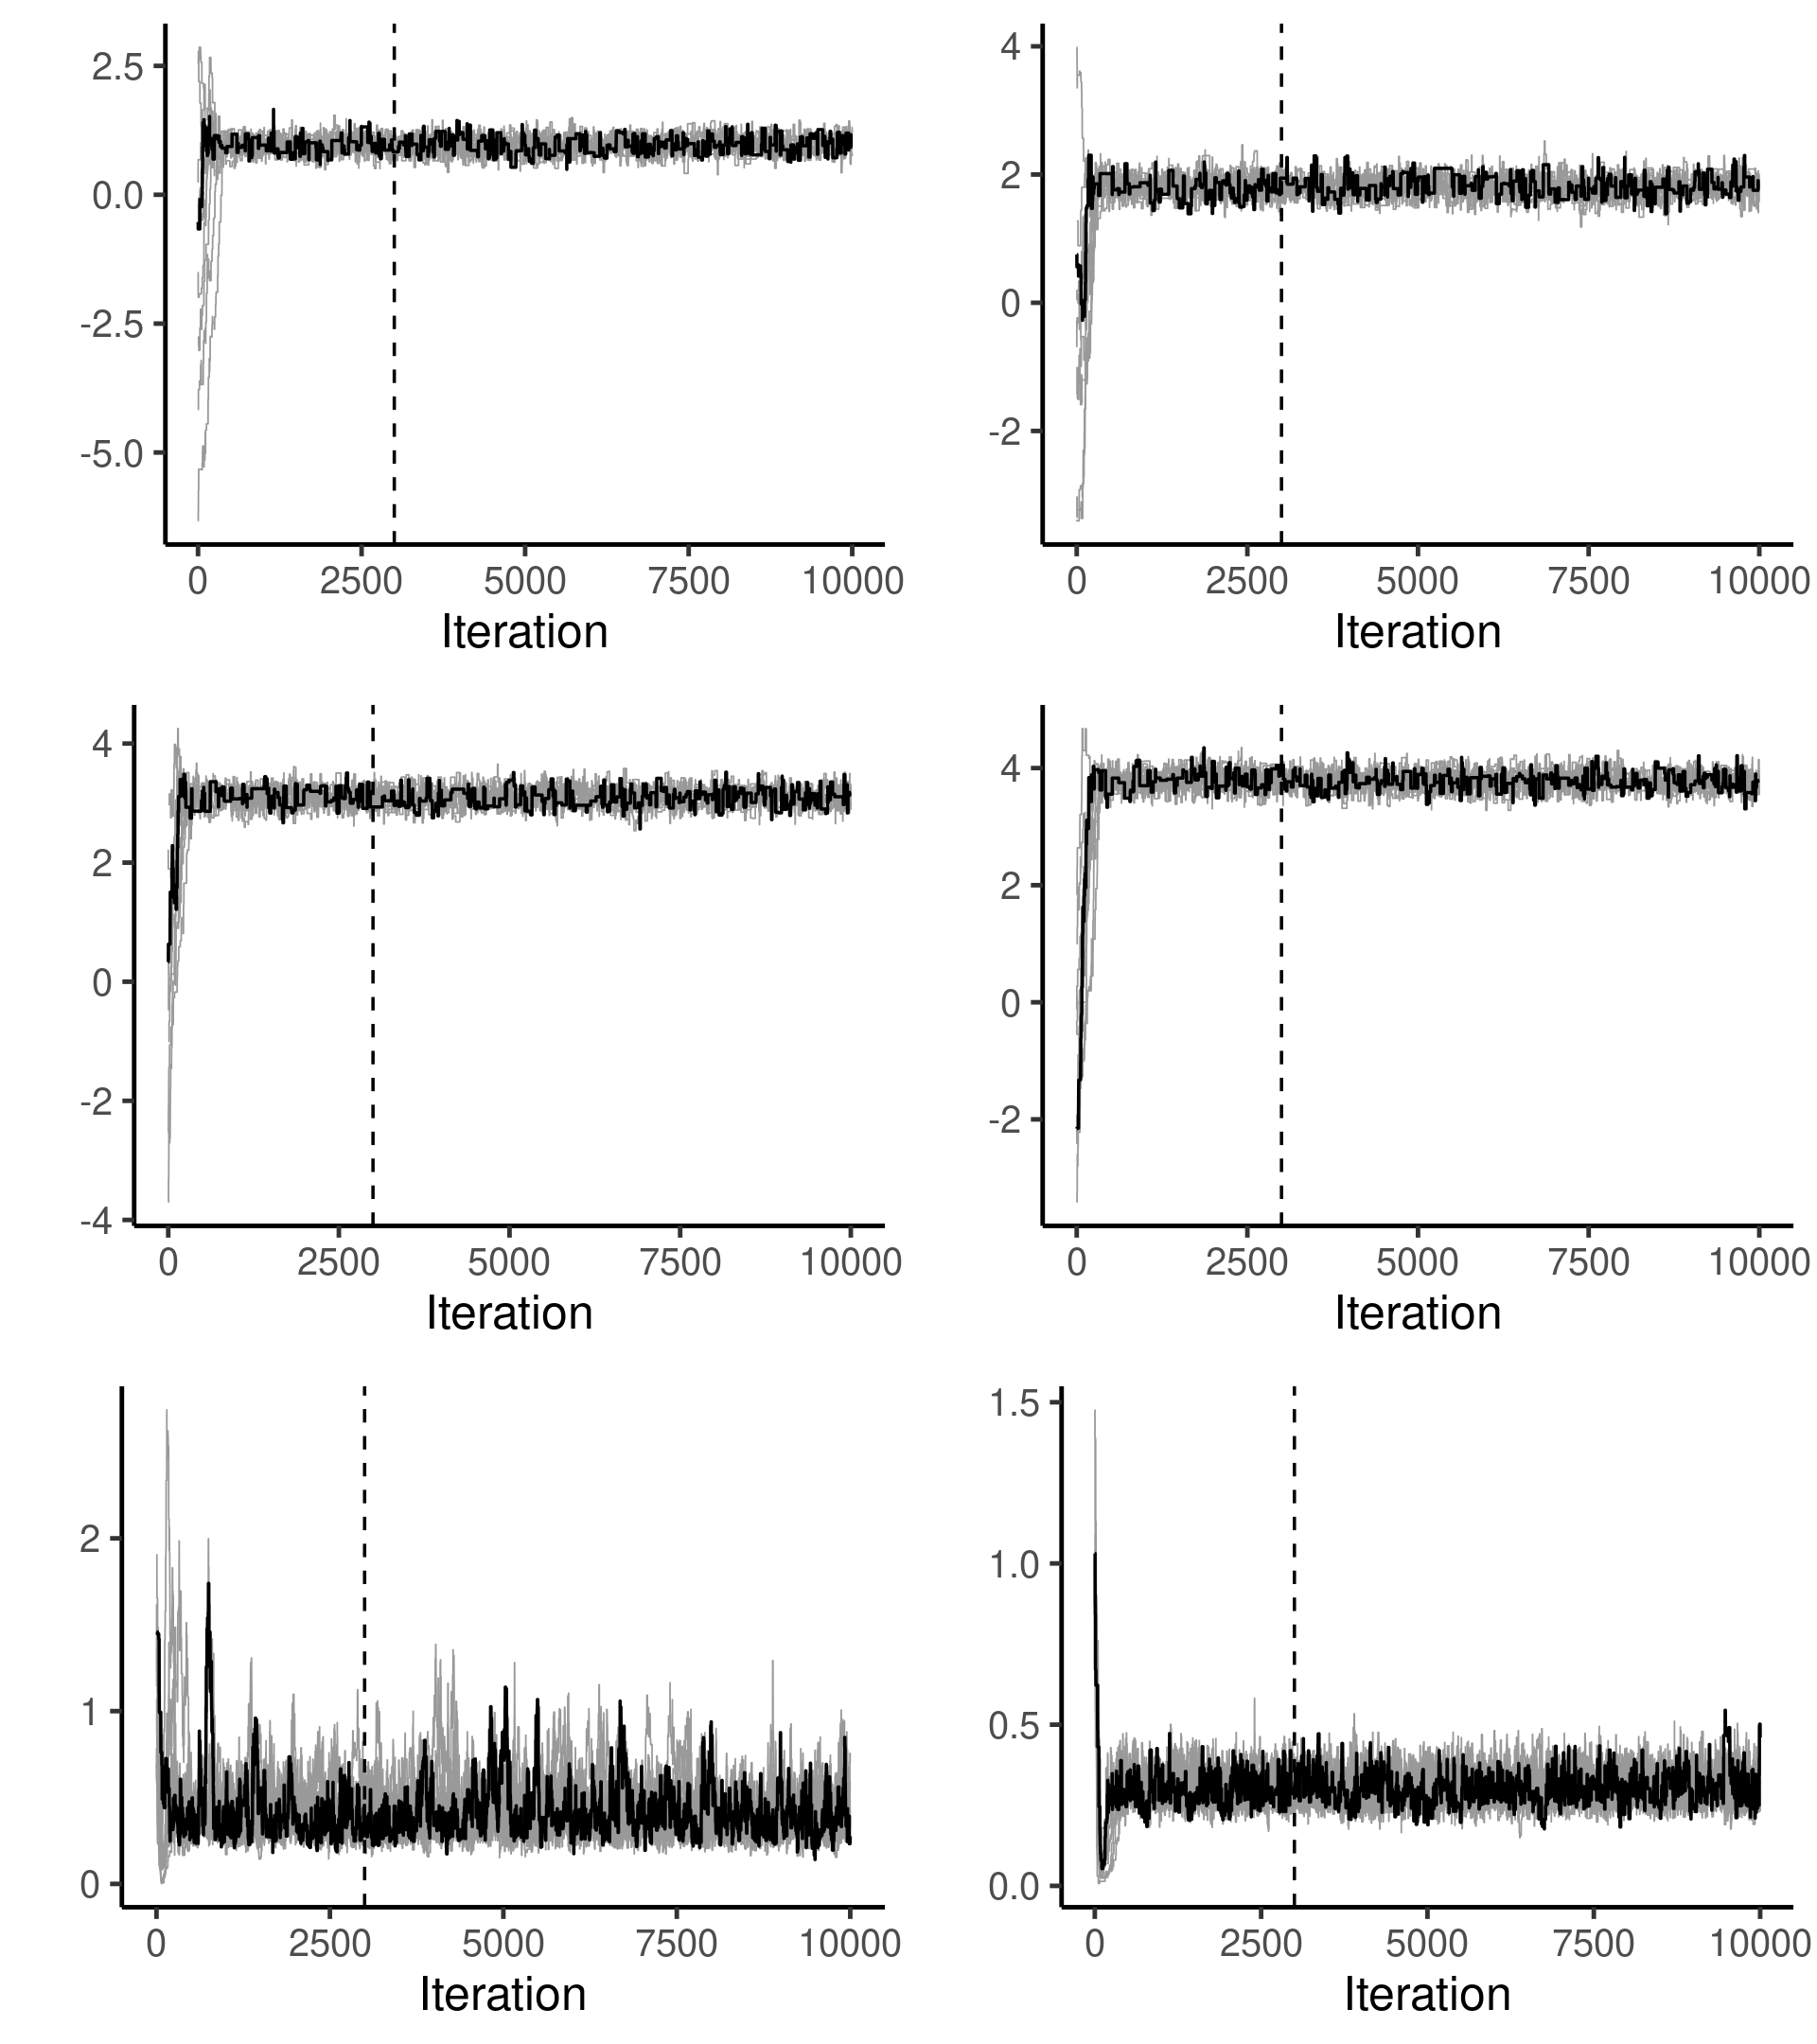

In [20]:
options(repr.plot.width=16, repr.plot.height=18) # Change plot size to 16 x 18
ggpubr::ggarrange(plt_trace[[1]], plt_trace[[2]], plt_trace[[3]], 
                  plt_trace[[4]], plt_trace[[5]], plt_trace[[6]],
                  nrow = 3, ncol = 2)

In [21]:
# Calculate acceptance rates
mean(sapply(mcmc_res, function(x){nrow(unique(x))/nsim}))

[1] 0.49286

The autocorrelation plots below indicate that there is considerable correlation among subsequent draws.

In [22]:
# ACF
plt_acf <- list(NULL)
for (i in 1:6) {
  # Get samples by parameter
  theta_i <- sapply(mcmc_res, function(x){x[, i]})
  if(i >= 5) theta_i <-1/theta_i # transform var to precision

  # Plot autocorrelations (pre thinning)
  acf_mat <- acf(theta_i, lag.max = 50, type = "correlation", plot = F)
  acf_i <- apply(sapply(c(1:nchains), function(x){acf_mat$acf[,x, x]}), 1, mean)
  plt_acf[[i]] <- ggplot(data = data.frame(lag = c(0:50), acf = acf_i), 
                aes(x = lag, y = acf)) + 
    geom_bar(stat = "identity") +
    ylab("Autocorrelation") +
    xlab("Lag") +
    theme_classic(base_size = 30) 
}#FOR

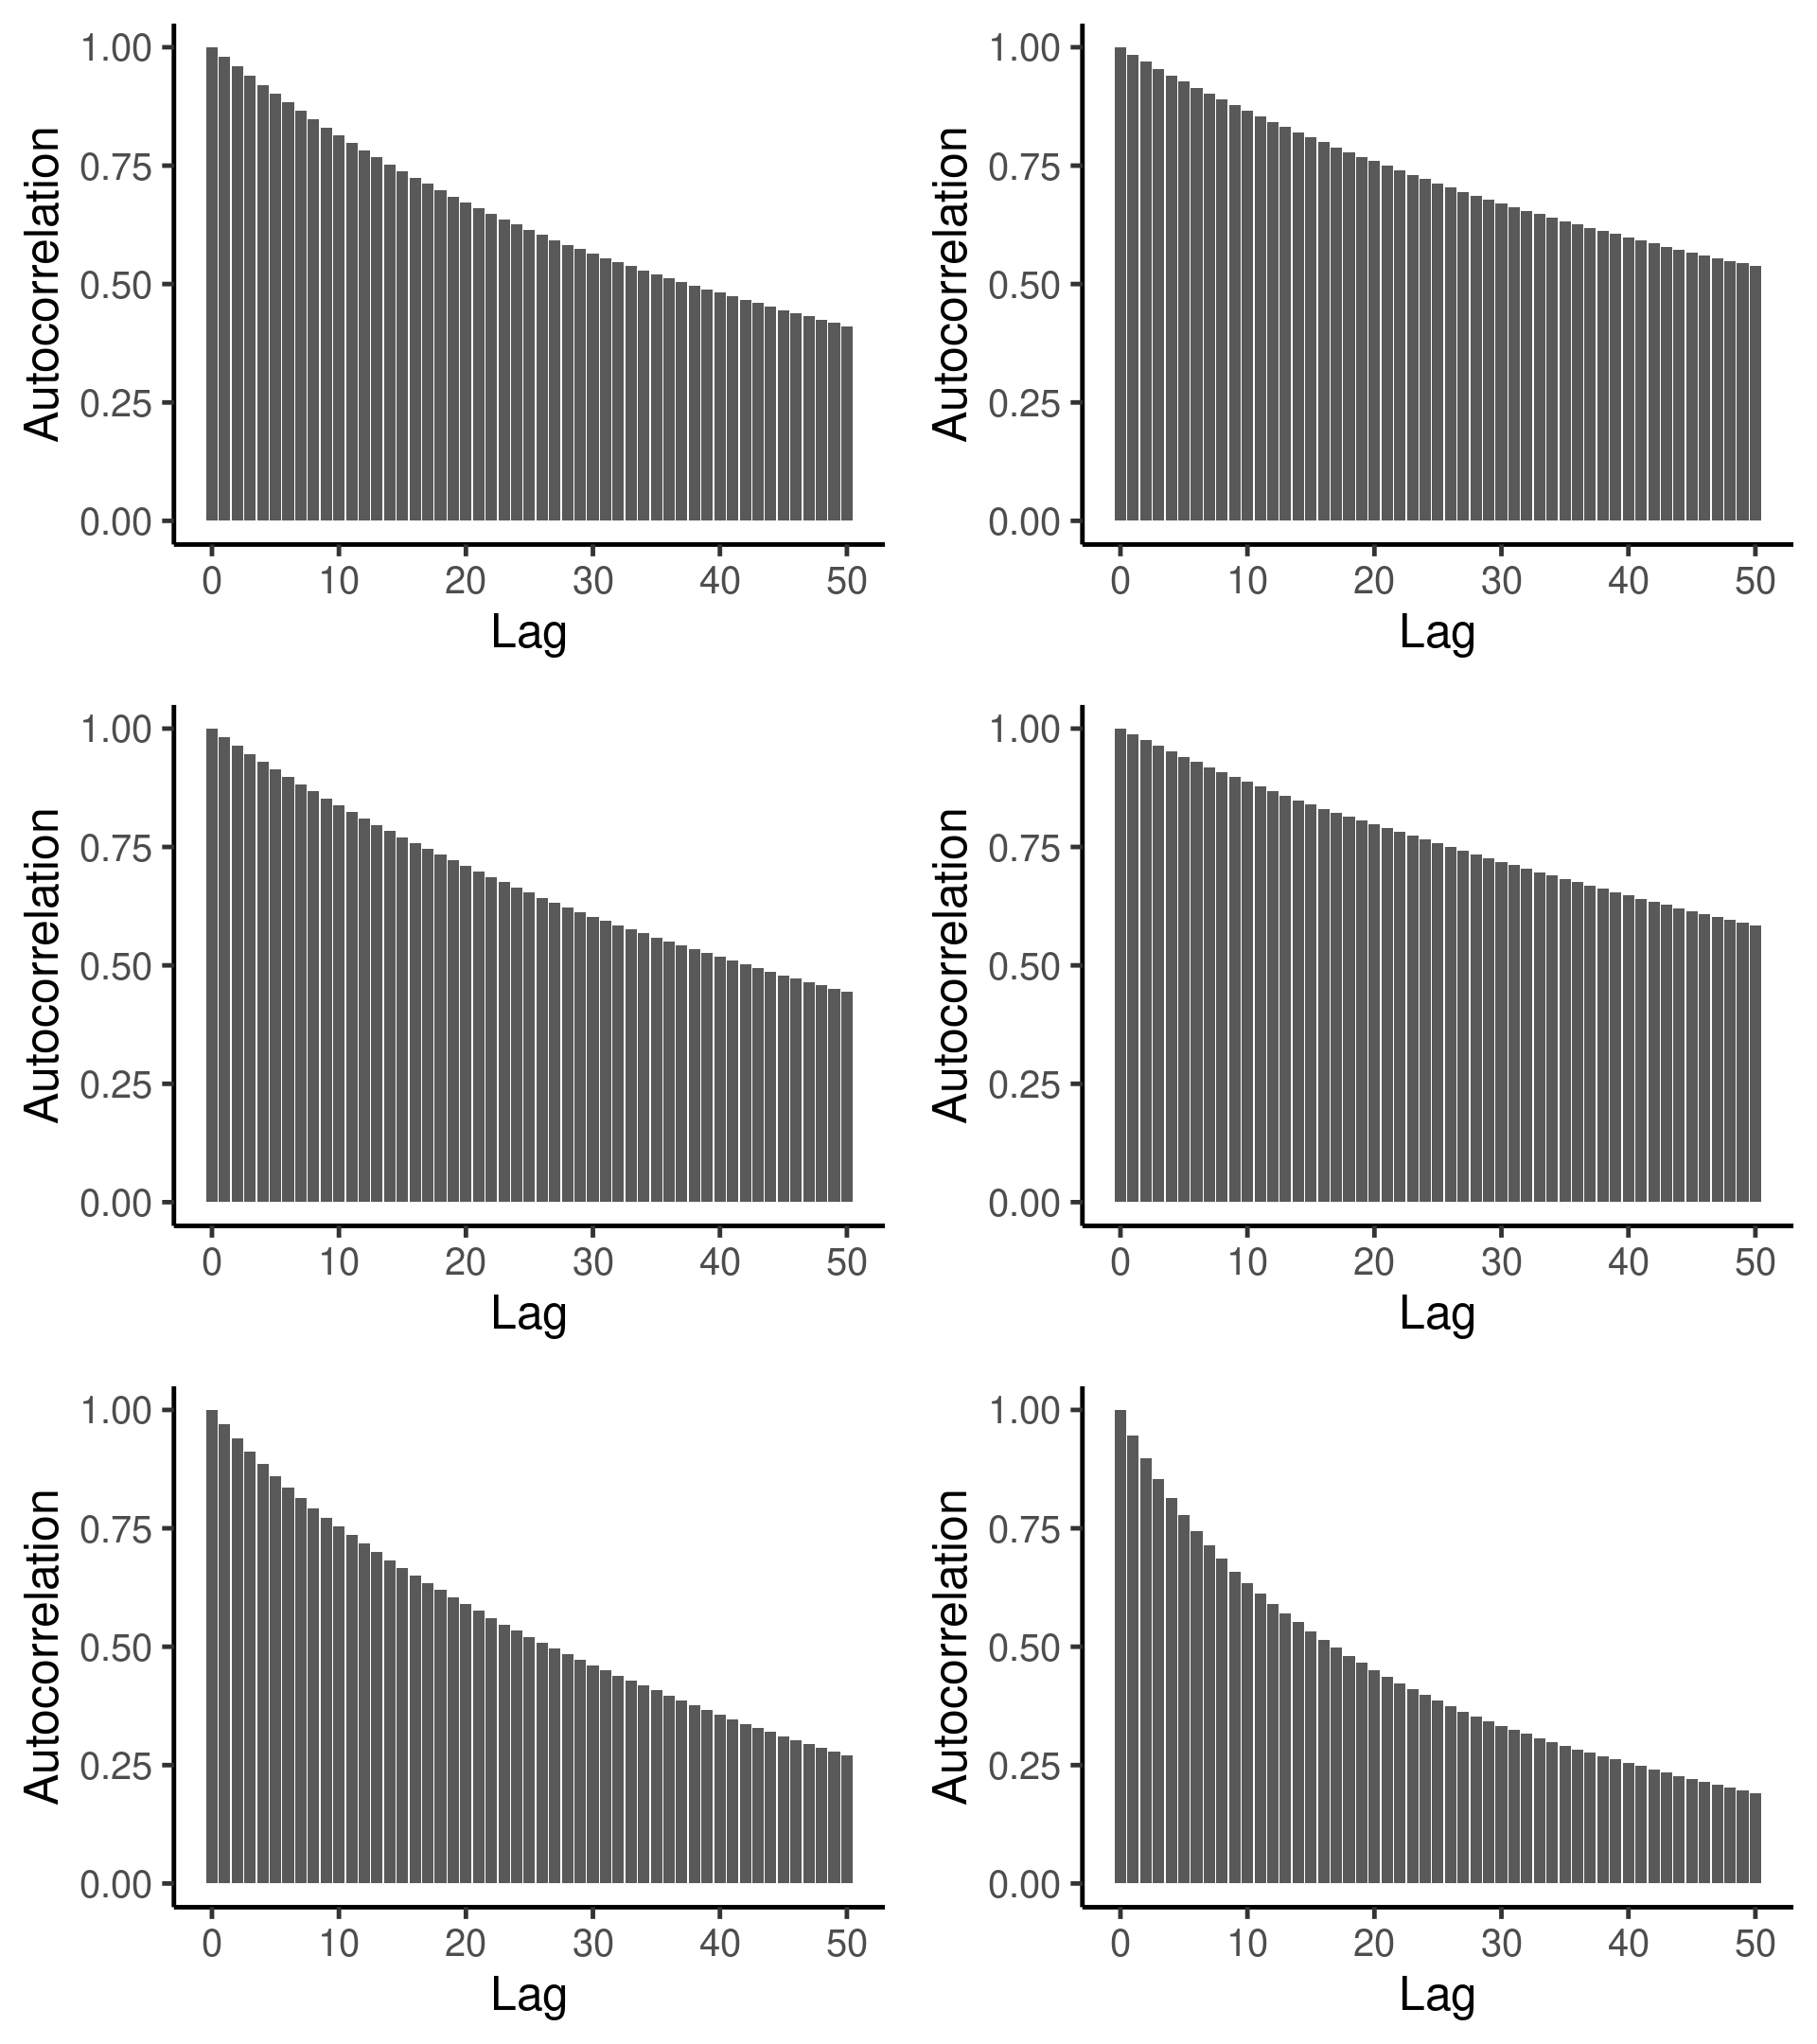

In [23]:
ggpubr::ggarrange(plt_acf[[1]], plt_acf[[2]], plt_acf[[3]], 
                  plt_acf[[4]], plt_acf[[5]], plt_acf[[6]],
                  nrow = 3, ncol = 2)

Although not strictly necessary, I thin the sample draws by selecting each 20th sample only. This results in quickly decreasing autocorrelation functions, as shown below.

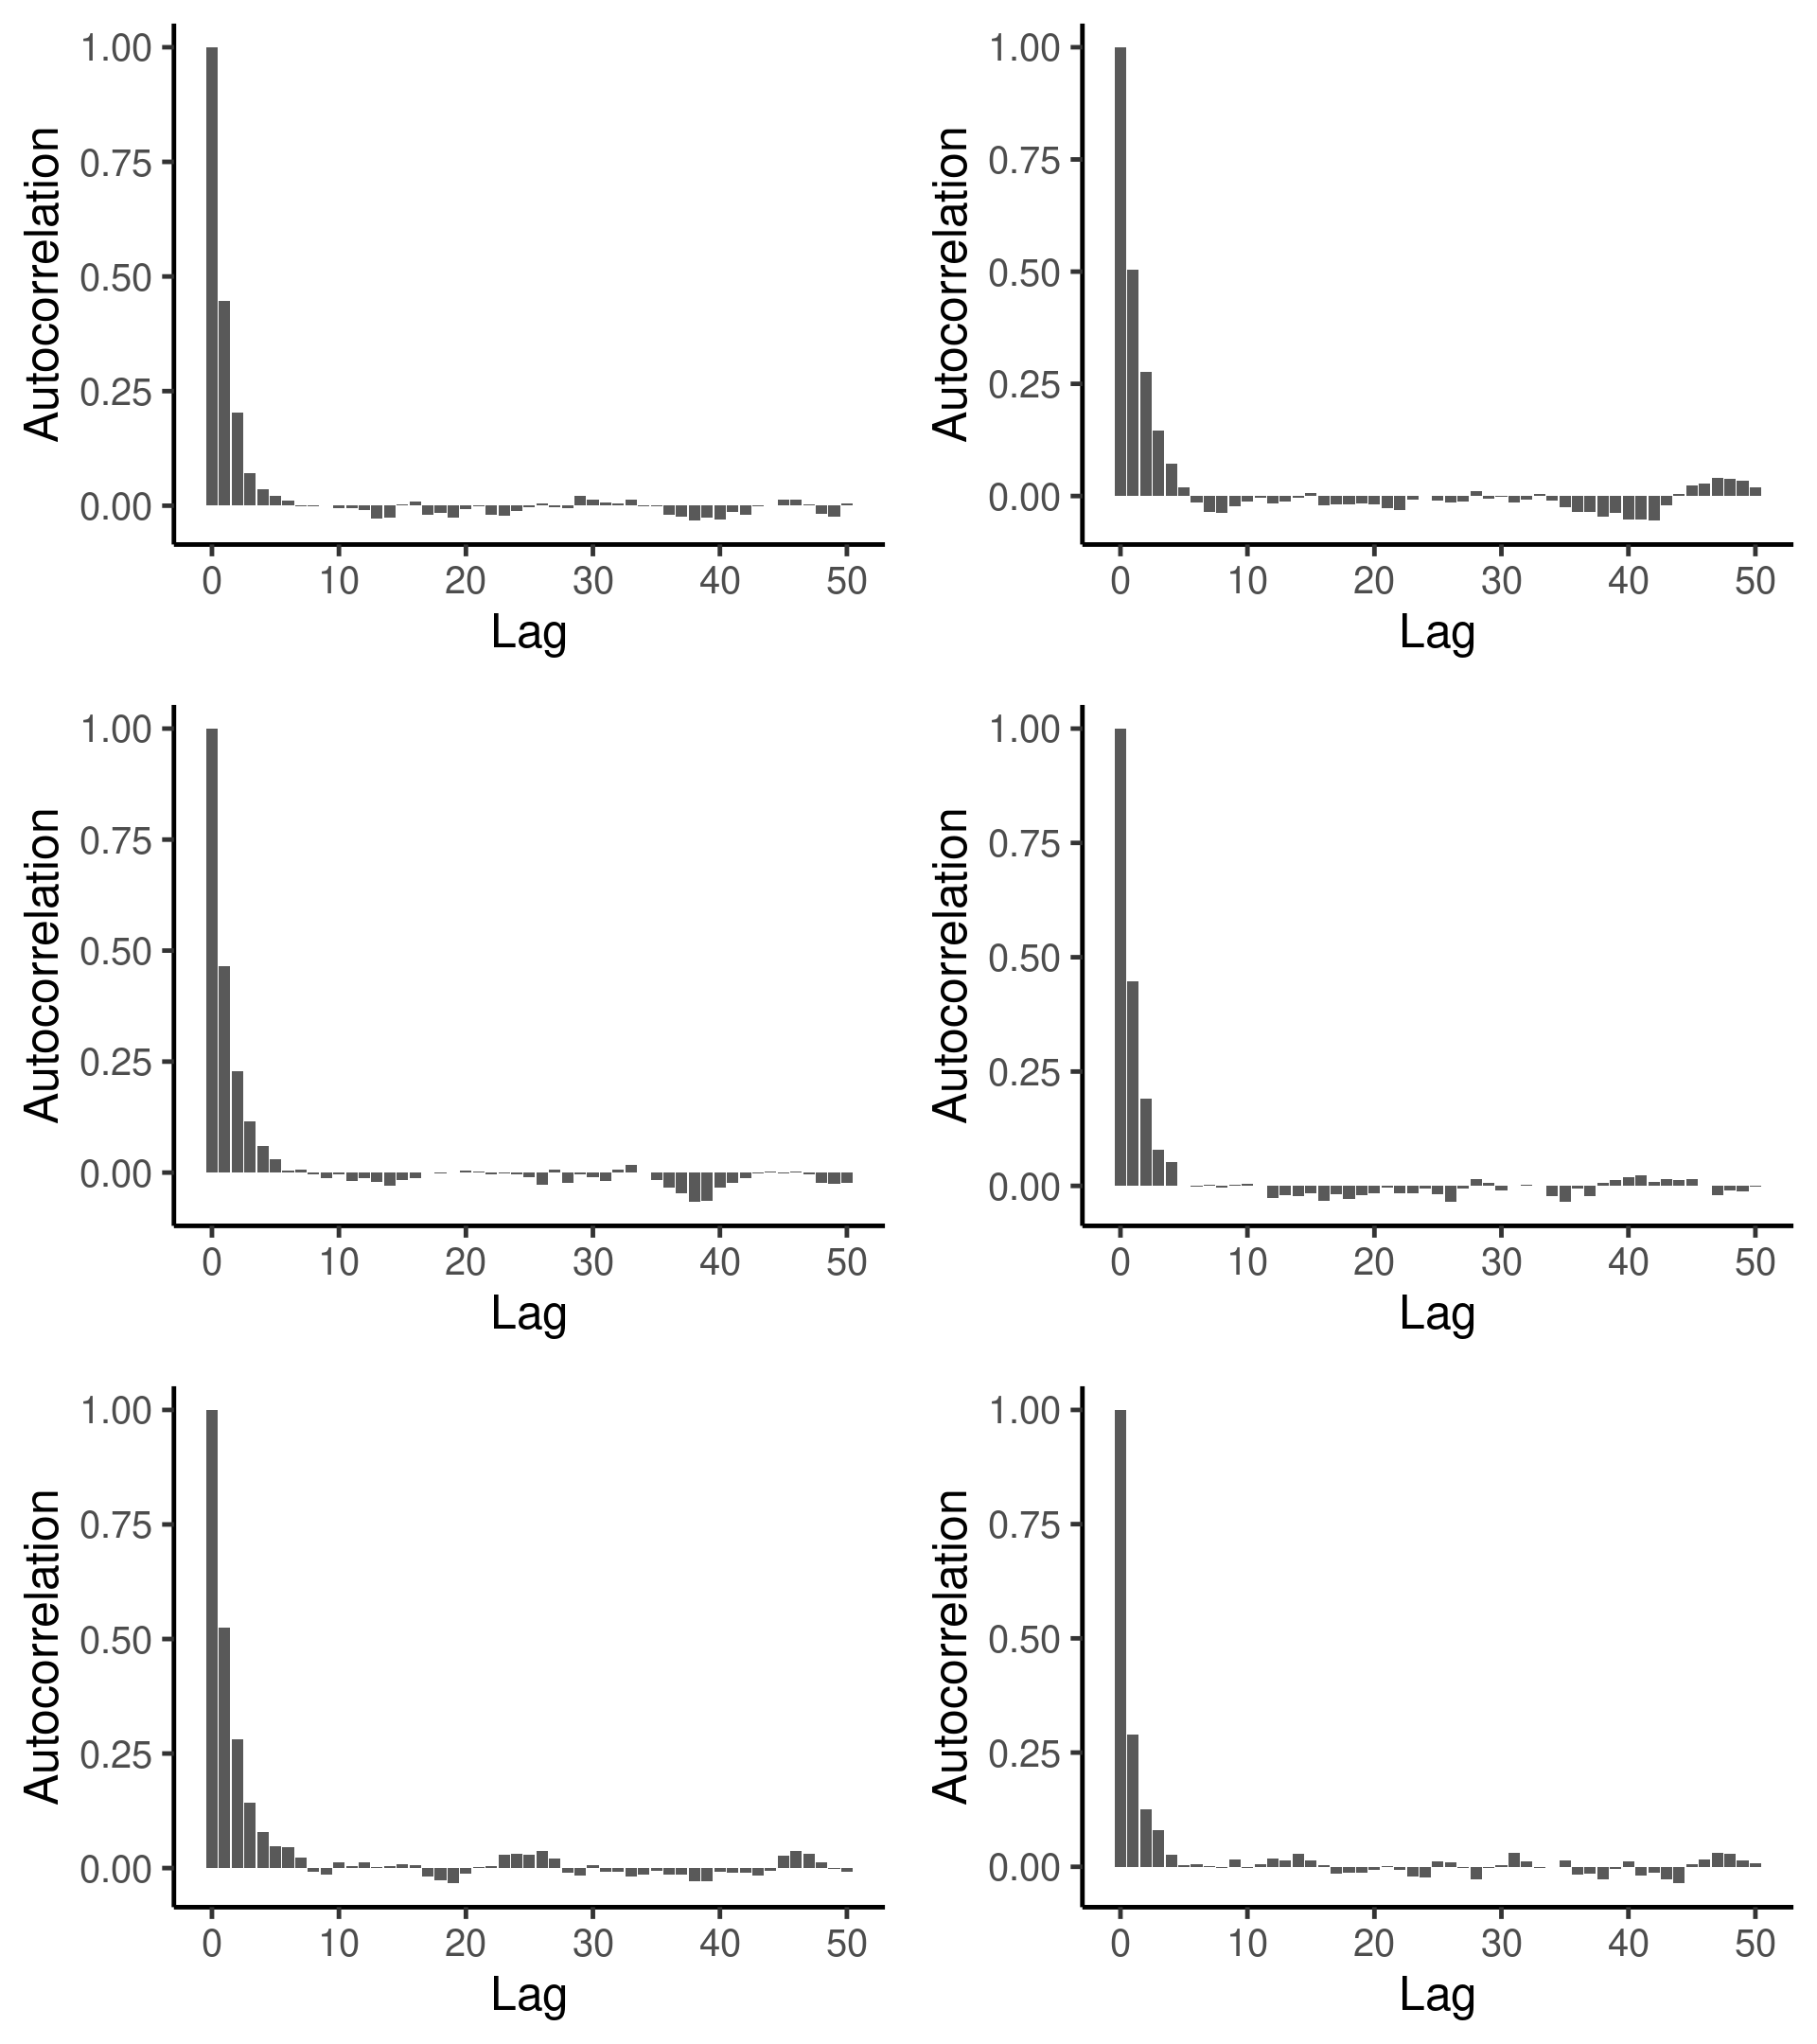

In [24]:
# ACF
plt_acf <- list(NULL)
for (i in 1:6) {
  # Get samples by parameter
  theta_i <- sapply(mcmc_res, function(x){x[, i]})
  if(i >= 5) theta_i <-1/theta_i # transform var to precision
    
  # Remove burn-in and thin samples
  theta_i <- theta_i[3000:nrow(theta_i), ]
  theta_i <- theta_i[seq(1, nrow(theta_i), 20), ] # Every 50th sample

  # Plot autocorrelations (pre thinning)
  acf_mat <- acf(theta_i, lag.max = 50, type = "correlation", plot = F)
  acf_i <- apply(sapply(c(1:nchains), function(x){acf_mat$acf[,x, x]}), 1, mean)
  plt_acf[[i]] <- ggplot(data = data.frame(lag = c(0:50), acf = acf_i), 
                aes(x = lag, y = acf)) + 
    geom_bar(stat = "identity") +
    ylab("Autocorrelation") +
    xlab("Lag") +
    theme_classic(base_size = 30) 
}#FOR

ggpubr::ggarrange(plt_acf[[1]], plt_acf[[2]], plt_acf[[3]], 
                  plt_acf[[4]], plt_acf[[5]], plt_acf[[6]],
                  nrow = 3, ncol = 2)

#### Section 2.7: Posterior Density Plots

Finally, the below figure shows the posterior density plots after thinning and burn-in removal. The samples from the posterior may now be used to calculate, for example, the Bayes estimator under square loss (i.e., the posterior mean).

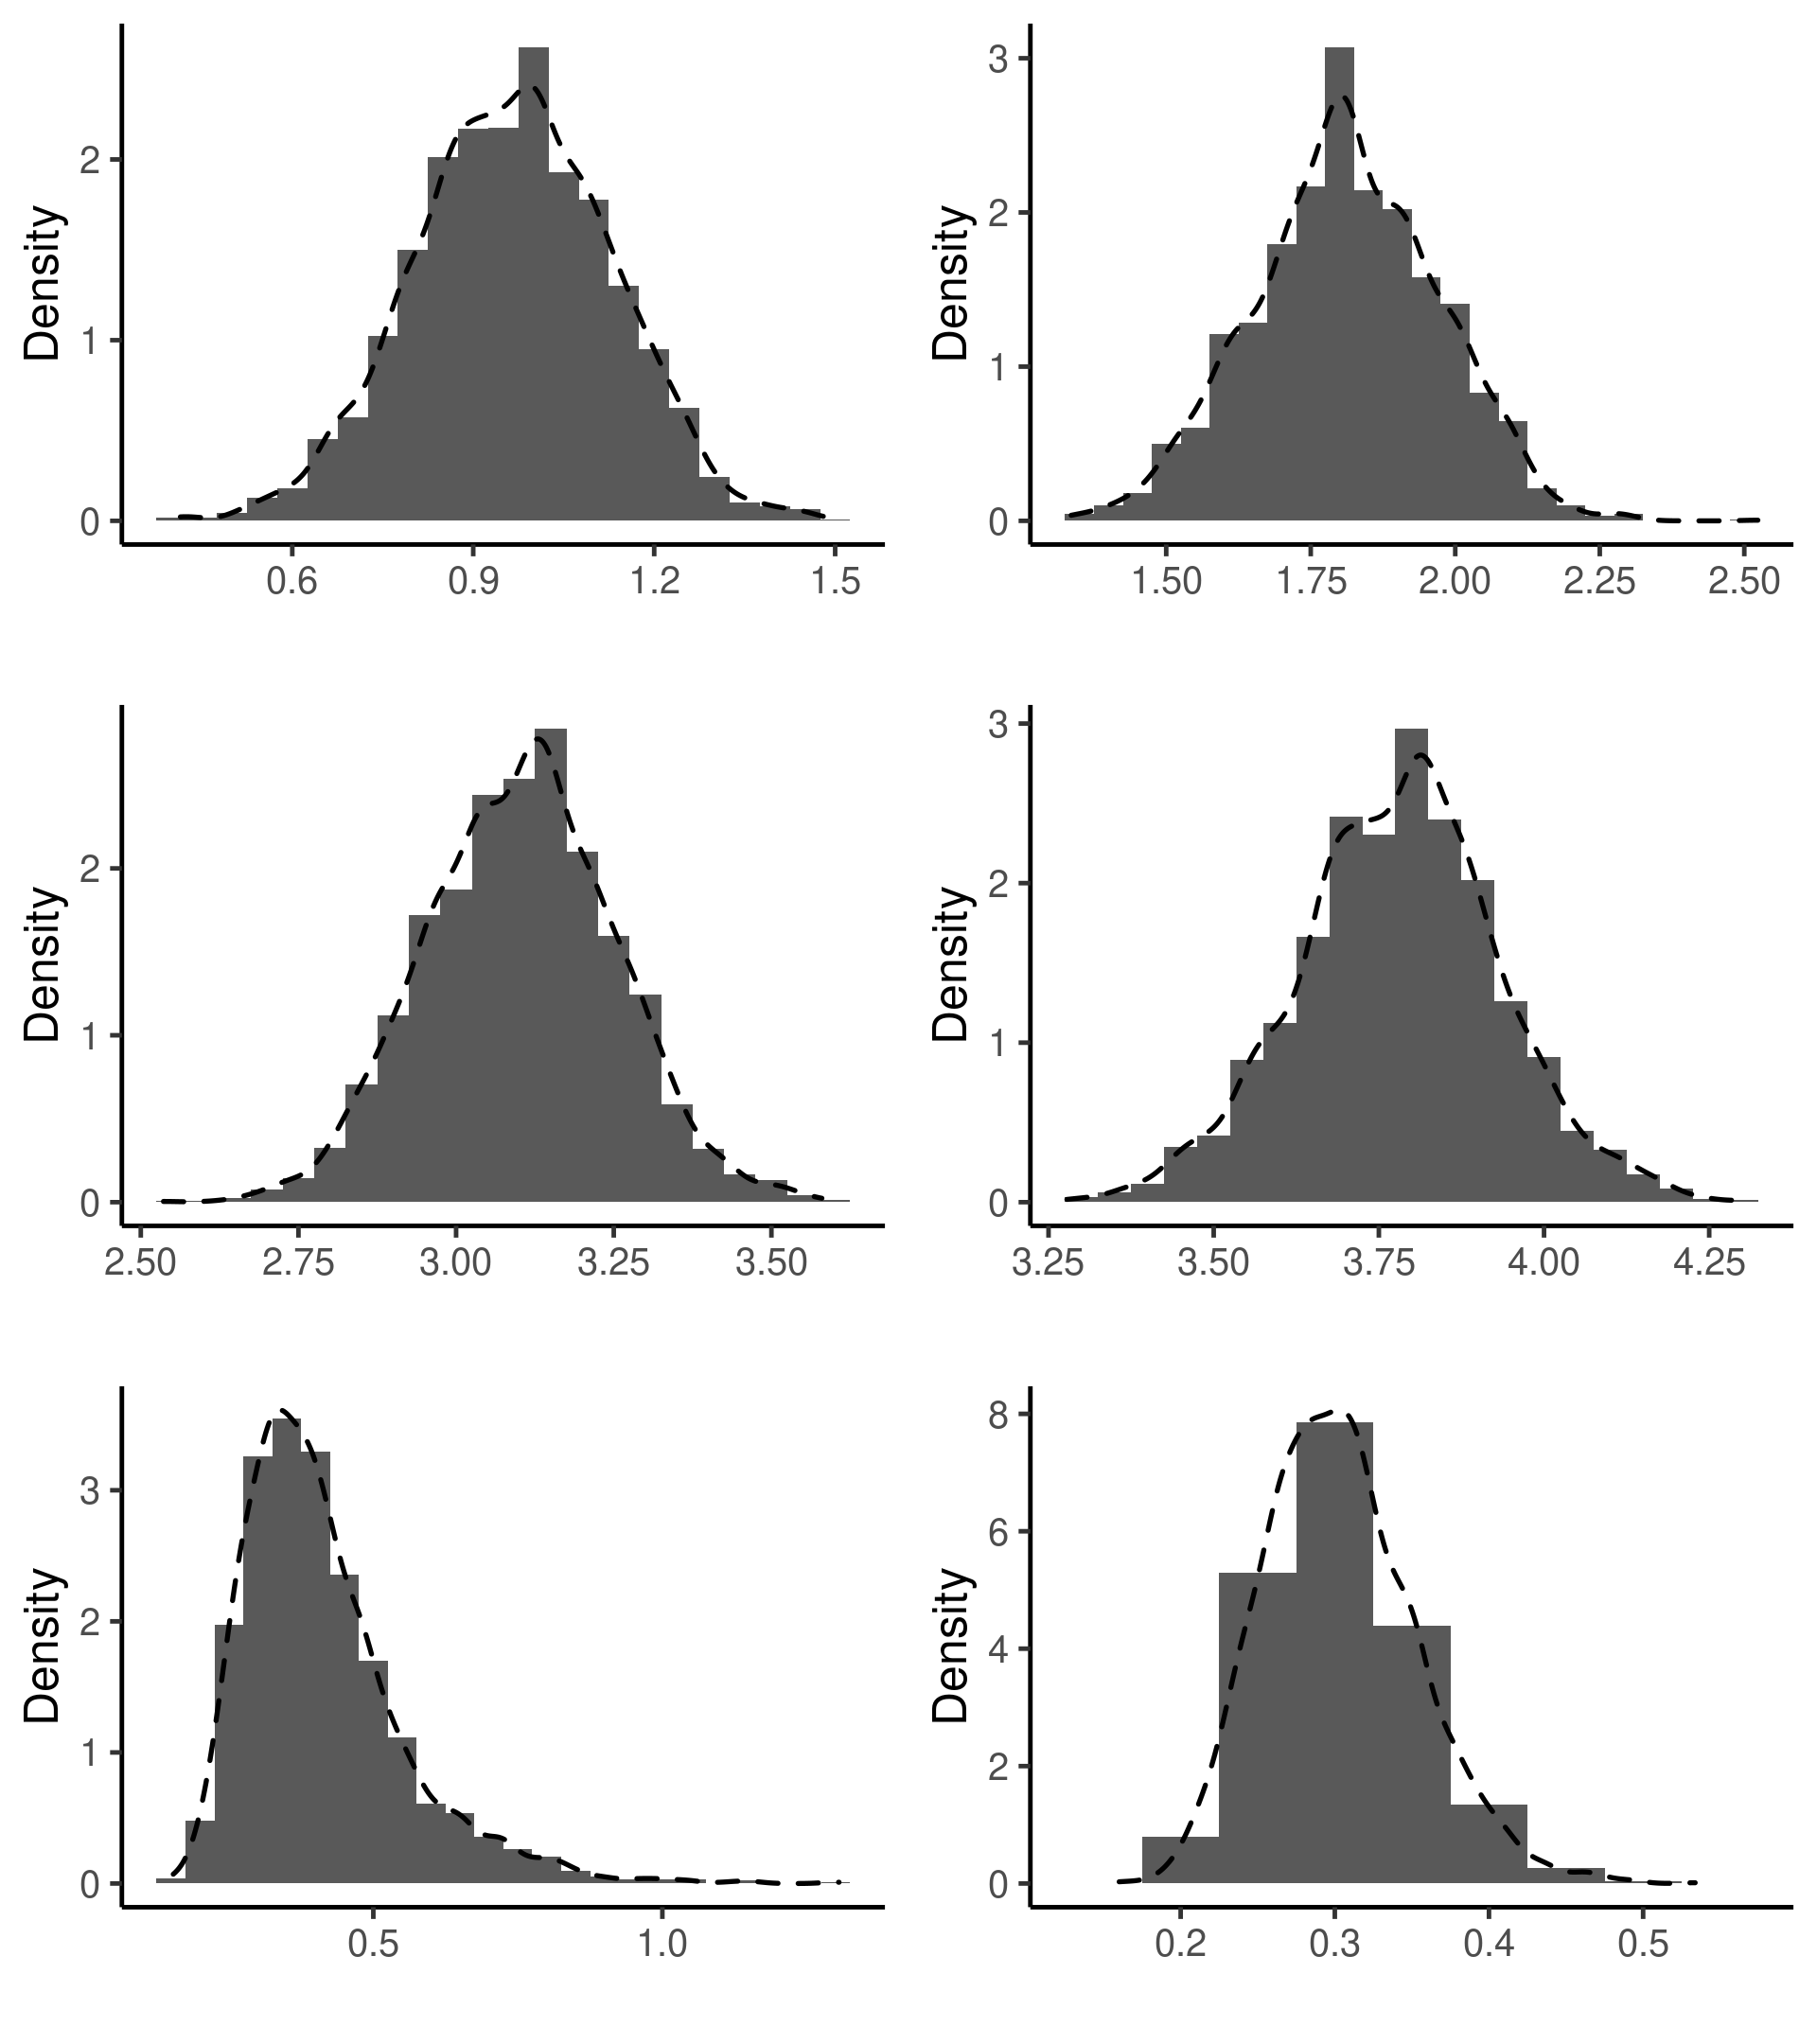

In [25]:
# Density
plt_density <- list(NULL)
for (i in 1:6) {
  # Get samples by parameter
  theta_i <- sapply(mcmc_res, function(x){x[, i]})
  if(i >= 5) theta_i <-1/theta_i # transform var to precision
    
  # Remove burn-in and thin samples
  theta_i <- theta_i[3000:nrow(theta_i), ]
  theta_i <- theta_i[seq(1, nrow(theta_i), 20), ] # Every 20th sample

  # Plot density (pre thinning)
  theta_i <- as.vector(theta_i) # combine chains
  plt_density[[i]] <- ggplot(data.frame(X = theta_i), aes(x = X, y=..density..)) + 
    geom_histogram(binwidth = 0.05) + 
    geom_density(size = 1.5, linetype = "dashed") + 
    ylab("Density") + 
    xlab("") +
    theme_classic(base_size = 30)
}#FOR

ggpubr::ggarrange(plt_density[[1]], plt_density[[2]], plt_density[[3]], 
                  plt_density[[4]], plt_density[[5]], plt_density[[6]],
                  nrow = 3, ncol = 2)